In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'raw_data.csv']

In [13]:
dates_cols = ['date', 'mlbDebutDate', 'DOB', 'rosterDate', 'pstatsDate']

In [14]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv',
                 parse_dates=dates_cols)

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (99) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### players data

In [15]:
# not all players are in the private test set
# the players in the test set are saved in the players.csv file

In [16]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [17]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [18]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

In [19]:
# player_in_test holds only the players in the test set

### filter players

In [20]:
from data.util import filter_by_date, filter_by_id

In [21]:
# filter only test players
df = filter_by_id(df, player_in_test)

In [22]:
# if you want to run on a sample,
# change sample_size to the number of players in the sample
sample_size = None

In [23]:
if sample_size is not None and sample_size > 0:
    df['target_avg'] = df[[f'target{i}' for i in range(1, 5)]].mean(axis=1)
    playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()
    df = filter_by_id(df, playerList['playerId'].head(sample_size))
    df.drop('target_avg', axis=1, inplace=True)

In [24]:
df.playerId.nunique()

1187

In [25]:
# player stats

In [26]:
df.head()

,playerId,target1,target2,target3,target4,date,home,gameType,isTie,gamesInSeries,...,year,inSeason,seasonPart,DOB,mlbDebutDate,birthCountry,weight,primaryPositionName,height,playerBMI
0,405395,0.151872,21.449416,0.112952,22.990196,2018-01-01,NaN,NaN,NaN,NaN,...,2018,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
1,405395,0.136406,10.978585,0.096403,15.669173,2018-01-02,NaN,NaN,NaN,NaN,...,2018,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
2,405395,0.064460,9.226190,0.101464,23.172829,2018-01-03,NaN,NaN,NaN,NaN,...,2018,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
3,405395,0.024217,10.170965,0.102448,35.359116,2018-01-04,NaN,NaN,NaN,NaN,...,2018,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661
4,405395,0.157556,4.294307,0.046517,12.347789,2018-01-05,NaN,NaN,NaN,NaN,...,2018,False,Offseason,1980-01-16,2001-04-02,Dominican Republic,106.59412,First Base,1.905,29.372661


In [27]:
list(df.columns)

['playerId',
 'target1',
 'target2',
 'target3',
 'target4',
 'date',
 'home',
 'gameType',
 'isTie',
 'gamesInSeries',
 'playerTeamWins',
 'playerTeamLosses',
 'playerTeamWinPct',
 'playerTeamWinner',
 'playerTeamScore',
 'opponentTeamId',
 'opponentTeamWins',
 'opponentTeamLosses',
 'opponentTeamWinPct',
 'opponentTeamScore',
 'teamScoreDiff',
 'pstatsDate',
 'battingOrder',
 'gamesPlayedBatting',
 'flyOuts',
 'groundOuts',
 'runsScored',
 'doubles',
 'triples',
 'homeRuns',
 'strikeOuts',
 'baseOnBalls',
 'intentionalWalks',
 'hits',
 'hitByPitch',
 'atBats',
 'caughtStealing',
 'stolenBases',
 'groundIntoDoublePlay',
 'groundIntoTriplePlay',
 'plateAppearances',
 'totalBases',
 'rbi',
 'leftOnBase',
 'sacBunts',
 'sacFlies',
 'catchersInterference',
 'pickoffs',
 'gamesPlayedPitching',
 'gamesStartedPitching',
 'completeGamesPitching',
 'shutoutsPitching',
 'winsPitching',
 'lossesPitching',
 'flyOutsPitching',
 'airOutsPitching',
 'groundOutsPitching',
 'runsPitching',
 'doublesPi

### preprocessing with pipelines

In [28]:
from typing import List
def forward_fill(df: pd.DataFrame, features: List[str],
                 on='playerId',
                 suffix: str = None,
                 limit: int =None):
    ffilled_df = df.groupby(on)[features].ffill(limit=limit)
    output_features = (features if suffix is None else
                       list(map(lambda f: suffix + f, features)))
    df.loc[:, output_features] = ffilled_df.to_numpy()
    return df

In [29]:
def gen_hardcoded_features(df: pd.DataFrame):
    # some feature eng for the dates
    df['pstatsTime'] = (df['date'] - pd.to_datetime(df['pstatsDate'])).dt.total_seconds()
    df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
    df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
    df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
    df['rostersTime'] = (df['date'] - pd.to_datetime(df['rosterDate'])).dt.total_seconds()
    df[['rostersTime', 'pstatsTime']] /= 60 * 60 * 24
    # normalize
    df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
    df['AwardWinner'] = df['awardId'].isna().astype(np.float64)
    return df

In [30]:
def fillna(df: pd.DataFrame, fill_value=-1):
    return df.fillna(-1)

In [31]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info

In [32]:
last_ffill_features = ['gameType',
 'isTie',
 'gamesInSeries',
 'playerTeamWins',
 'playerTeamLosses',
 'playerTeamWinPct',
 'playerTeamWinner',
 'playerTeamScore',
 'opponentTeamWins',
 'opponentTeamLosses',
 'opponentTeamWinPct',
 'opponentTeamScore',
 'teamScoreDiff',
 'opponentTeamId']
                          
                          
inplace_ffill_features = ['numberOfFollowers',
                          'teamFollowers',
                          'status',
                          'teamId',
                          'rosterDate',
                          'pstatsDate']

In [33]:
# transformer for filling nan values with past valid values
# transformer for generating some hardcoded features
inplace_fill_forward_tmf = FunctionTransformer(forward_fill,
                                               kw_args={'features': inplace_ffill_features})
last_fill_forward_tmf = FunctionTransformer(forward_fill,
                                            kw_args={'features': last_ffill_features,
                                                     'suffix': 'last_'})
join_players_tmf = FunctionTransformer(join_players_info, kw_args={'path_to_players': RAW_PATH / 'players.csv'})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [34]:
# creating pipeline
ffill_and_gen_harcoded_feat = Pipeline([('inplace_fill_forward', inplace_fill_forward_tmf),
                                        ('last_fill_forward', last_fill_forward_tmf),
                                       ('hardcoded_feat', harcoded_feat_tmf)])

In [35]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [36]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year', 'primaryPositionName',
              'status', 'teamId', 'awardId', 'gameType',
              'opponentTeamId', 'last_opponentTeamId', 'last_gameType', 'home']

categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [37]:
# for the statistics, we will compute them and then resuse them
stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'], windows=[90], drop_index=False)
target_stats_tmf = PdColumnTransformer([('gen_stats', stats_gen_tmf, pp_cols)])
target_stats_table = target_stats_tmf.fit_transform(df)


In [38]:
target_stats_table.head()

,playerId,date,target1__mean__90d,target1__median__90d,target1__std__90d,target2__mean__90d,target2__median__90d,target2__std__90d,target3__mean__90d,target3__median__90d,target3__std__90d,target4__mean__90d,target4__median__90d,target4__std__90d
0,405395,2018-01-01,0.151872,0.151872,NaN,21.449417,21.449417,NaN,0.112952,0.112952,NaN,22.990196,22.990196,NaN
1,405395,2018-01-02,0.144139,0.144139,0.010936,16.214001,16.214001,7.403996,0.104677,0.104677,0.011702,19.329685,19.329685,5.176745
2,405395,2018-01-03,0.117580,0.136406,0.046648,13.884730,10.978585,6.609544,0.103606,0.101464,0.008480,20.610733,22.990196,4.280490
3,405395,2018-01-04,0.094239,0.100433,0.060248,12.956289,10.574775,5.707194,0.103317,0.101956,0.006948,24.297829,23.081512,8.160501
4,405395,2018-01-05,0.106902,0.136406,0.059365,11.223893,10.170965,6.279732,0.091957,0.101464,0.026104,21.907820,22.990196,8.860362


In [39]:
## merge computed statistics
reuse_computed_stats = Pipeline([('merge_stats', FeaturesTable(target_stats_table, lags=[60], clip_max=True)),
#                                  ('fillnan', FunctionTransformer(fillna)),
#                                  ('normalize', PdScaleNorm())
                                ])

In [40]:
# for continuous features, we will filter them and then fill nan values and normalize them

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

# get the rest of the continuous features
continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures(ignore_features=categories +
                                                                           pp_cols +
                                                                           ['target_avg'])),
#                                 ('fillnan_median', fillnan_median_tmf),
#                                 ('fillnan', FunctionTransformer(fillna)),
#                                 ('normalize', PdScaleNorm())
                               ])

In [41]:
# putting all features generation steps together
all_features_tmf = PdFeatureUnion([('stats', reuse_computed_stats), 
                                   ('cont_feat', continuous_feat_tmf), 
                                  ('cats', categories_tmf),
                                  ])

In [42]:
# main pipeline with all steps 
pipeline = Pipeline([('core_features', ffill_and_gen_harcoded_feat),
                     ('features_generation', all_features_tmf)])

In [43]:
pipeline

Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7fcfd1f3adc0>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate']})),
                                 ('last_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7fcfd1f3adc0>,
                                                      kw_args={'features': ['g...
                     

In [44]:
from data.split import SplitData

In [45]:
# split the data on 2021-03-01 with a valid ds of 61 days
sp = SplitData("2021-03-01", test_days=61)

In [46]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [47]:
%%time
# train the pipeline only with the train dataset
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 14.6 s, sys: 1.96 s, total: 16.6 s
Wall time: 16.7 s


Pipeline(steps=[('core_features',
                 Pipeline(steps=[('inplace_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7fcfd1f3adc0>,
                                                      kw_args={'features': ['numberOfFollowers',
                                                                            'teamFollowers',
                                                                            'status',
                                                                            'teamId',
                                                                            'rosterDate',
                                                                            'pstatsDate']})),
                                 ('last_fill_forward',
                                  FunctionTransformer(func=<function forward_fill at 0x7fcfd1f3adc0>,
                                                      kw_args={'features': ['g...
                     

In [48]:
%%time
# transform all dataset
features = pipeline.transform(df)

CPU times: user 16.6 s, sys: 2.51 s, total: 19.1 s
Wall time: 19.2 s


In [49]:
pd.options.display.max_rows = len(features.columns)
features.T.head(len(features.columns))

,0,1,2,3,4,5,6,7,8,9,...,1443382,1443383,1443384,1443385,1443386,1443387,1443388,1443389,1443390,1443391
target1__mean__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.391239e-02
target1__median__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
target1__std__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.319845e-01
target2__mean__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.445051e+00,2.530756e+00,2.580583e+00,2.659379e+00,2.743894e+00,2.793519e+00,2.852765e+00,2.875587e+00,2.965806e+00,3.442276e+00
target2__median__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.165432e-01,7.609572e-01,8.230731e-01,9.346975e-01,1.013046e+00,1.025530e+00,1.034818e+00,1.040071e+00,1.056387e+00,1.082564e+00
target2__std__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.229539e+00,7.245929e+00,7.243749e+00,7.253926e+00,7.273668e+00,7.269972e+00,7.268677e+00,7.262842e+00,7.277138e+00,8.398266e+00
target3__mean__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.533152e-01,1.668254e-01,1.742816e-01,1.763568e-01,1.770192e-01,1.778501e-01,1.784175e-01,1.794348e-01,1.795836e-01,2.178821e-01
target3__median__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
target3__std__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.977857e-01,8.054192e-01,8.069622e-01,8.067491e-01,8.066272e-01,8.064812e-01,8.063726e-01,8.062028e-01,8.061705e-01,8.763618e-01
target4__mean__90d__60lag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.515454e+00,1.514864e+00,1.517962e+00,1.505702e+00,1.484562e+00,1.492430e+00,1.494894e+00,1.493768e+00,1.493599e+00,1.511075e+00


In [50]:
# change the dtypes of the target (pytorch likes float32 and not float64)
df[target_cols] = df[target_cols].astype(np.float32)

In [51]:
train_idx.shape

(1443392,)

In [52]:
train_idx.shape

(1443392,)

In [53]:
train_data = sp.filter(features, train_idx)

raw_train_df = sp.filter(df, train_idx)

In [54]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [55]:
train_data.shape, raw_train_df.shape

((1370985, 130), (1370985, 131))

In [56]:
valid_data.shape, raw_valid_df.shape

((72407, 130), (72407, 131))

In [57]:
# add the target to features ds
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [58]:
# # filter continuous features
continuous_feat = features.columns.drop(categories)

In [59]:
features_list = list(continuous_feat) + categories

In [60]:
features_list

['target1__mean__90d__60lag',
 'target1__median__90d__60lag',
 'target1__std__90d__60lag',
 'target2__mean__90d__60lag',
 'target2__median__90d__60lag',
 'target2__std__90d__60lag',
 'target3__mean__90d__60lag',
 'target3__median__90d__60lag',
 'target3__std__90d__60lag',
 'target4__mean__90d__60lag',
 'target4__median__90d__60lag',
 'target4__std__90d__60lag',
 'isTie',
 'gamesInSeries',
 'playerTeamWins',
 'playerTeamLosses',
 'playerTeamWinPct',
 'playerTeamScore',
 'opponentTeamWins',
 'opponentTeamLosses',
 'opponentTeamWinPct',
 'opponentTeamScore',
 'teamScoreDiff',
 'battingOrder',
 'gamesPlayedBatting',
 'flyOuts',
 'groundOuts',
 'runsScored',
 'doubles',
 'triples',
 'homeRuns',
 'strikeOuts',
 'baseOnBalls',
 'intentionalWalks',
 'hits',
 'hitByPitch',
 'atBats',
 'caughtStealing',
 'stolenBases',
 'groundIntoDoublePlay',
 'groundIntoTriplePlay',
 'plateAppearances',
 'totalBases',
 'rbi',
 'leftOnBase',
 'sacBunts',
 'sacFlies',
 'catchersInterference',
 'pickoffs',
 'game

In [61]:
from omegaconf import OmegaConf

parameters = {
 'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}
config = {'hp': parameters,
          'features': features_list,
          'categories': categories,
          'target_cols': target_cols}
config = OmegaConf.create(config)

In [62]:
config

{'hp': {'objective': 'mae', 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'n_estimators': 100000, 'learning_rate': 0.1, 'random_state': 42}, 'features': ['target1__mean__90d__60lag', 'target1__median__90d__60lag', 'target1__std__90d__60lag', 'target2__mean__90d__60lag', 'target2__median__90d__60lag', 'target2__std__90d__60lag', 'target3__mean__90d__60lag', 'target3__median__90d__60lag', 'target3__std__90d__60lag', 'target4__mean__90d__60lag', 'target4__median__90d__60lag', 'target4__std__90d__60lag', 'isTie', 'gamesInSeries', 'playerTeamWins', 'playerTeamLosses', 'playerTeamWinPct', 'playerTeamScore', 'opponentTeamWins', 'opponentTeamLosses', 'opponentTeamWinPct', 'opponentTeamScore', 'teamScoreDiff', 'battingOrder', 'gamesPlayedBatting', 'flyOuts', 'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns', 'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch', 'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay', 'groundIntoTriplePlay', 'plateAppearances', 'tota

In [63]:
from train.lgbm import run_lgbm

In [64]:
# models are train with a run_fn, the run_fn return and ModelOutput (src/train/core.py)
# ModelOutput holds the trained models, a predict_fn to predict new data and
# the predictions of the validation set 

In [65]:
lgbm_output = run_lgbm(config, train_data, valid_data)

target1


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['awardId', 'gameType', 'home', 'last_gameType', 'last_opponentTeamId', 'opponentTeamId', 'playerId', 'primaryPositionName', 'seasonPart', 'status', 'teamId', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 1.38425
[200]	valid_0's l1: 1.38135
[300]	valid_0's l1: 1.3805
[400]	valid_0's l1: 1.37848
[500]	valid_0's l1: 1.37585
[600]	valid_0's l1: 1.37553
[700]	valid_0's l1: 1.37547
[800]	valid_0's l1: 1.37547
[900]	valid_0's l1: 1.37547
[1000]	valid_0's l1: 1.37546
[1100]	valid_0's l1: 1.37475
[1200]	valid_0's l1: 1.3746
[1300]	valid_0's l1: 1.37414
[1400]	valid_0's l1: 1.37413
[1500]	valid_0's l1: 1.37413
[1600]	valid_0's l1: 1.37403
[1700]	valid_0's l1: 1.37357
[1800]	valid_0's l1: 1.37293
[1900]	valid_0's l1: 1.3729
[2000]	valid_0's l1: 1.37189
[2100]	valid_0's l1: 1.37153
[2200]	valid_0's l1: 1.37151
[2300]	valid_0's l1: 1.3713
[2400]	valid_0's l1: 1.3706
Early stopping, best iteration is:
[2341]	valid_0's l1: 1.37056
target2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 3.05513
Early stopping, best iteration is:
[52]	valid_0's l1: 3.00759
target3
Training until validatio

In [66]:
from evaluate.metrics import compute_metrics

In [67]:
valid_test_prediction = pd.DataFrame(lgbm_output.prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]

In [68]:
is_test_pred = valid_test_prediction['date'] >= '2021-04-01'

valid_prediction, test_prediction = (valid_test_prediction.loc[~is_test_pred, :],
                                     valid_test_prediction.loc[is_test_pred, :])

In [69]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 1.8514514754518663,
 'mae_1': 1.3705619133894666,
 'mae_2': 3.007590240041074,
 'mae_3': 1.2336345205789154,
 'mae_4': 1.794019227798009}

In [70]:
# metrics from 2021-03-01 up to 2021-03-31
compute_metrics(valid_prediction)

{'mae_mean': 2.1443256495053937,
 'mae_1': 1.5189713759931252,
 'mae_2': 3.60742042216449,
 'mae_3': 1.4976825925457893,
 'mae_4': 1.953228207318171}

In [71]:
# metrics from 2021-04-01 up to 2021-04-30
compute_metrics(test_prediction)

{'mae_mean': 1.5488148289298878,
 'mae_1': 1.2172054686990195,
 'mae_2': 2.387765718513544,
 'mae_3': 0.9607848462131455,
 'mae_4': 1.629503282293842}

In [72]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

In [73]:
def feature_importance(features, model):
    fi = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    fi.sort_values(by='importance', ascending=False, inplace=True)
    return fi

def compute_fi(features, models):
    fi = [feature_importance(features, _model).assign(target=f'target{target+1}')
      for target, _model in enumerate(models)]
    fi = pd.concat(fi)
    fi = fi.pivot('feature', 'target', 'importance')
    fi = fi * 100 / fi.sum()
    fi['mean'] = fi.mean(axis=1)
    fi.sort_values(by='mean', ascending=False, inplace=True)
    return fi

In [74]:
len(features_list)

130

In [75]:
lgbm_output.model[0].feature_importances_.shape

(130,)

In [76]:
fi = compute_fi(features_list, lgbm_output.model)

In [77]:
fi.head(100)

target,target1,target2,target3,target4,mean
feature,,,,,
playerId,59.837676,46.089744,61.310541,46.690998,53.482240
seasonPart,8.129005,13.141026,6.381766,7.712895,8.841173
playerTSinceDebut,8.543358,2.628205,3.494777,7.854015,5.630089
pstatsTime,1.701552,6.602564,1.576448,2.238443,3.029752
rostersTime,0.654991,4.935897,3.646724,2.214112,2.862931
teamId,3.317671,2.051282,1.101614,4.700730,2.792824
year,0.783141,3.141026,4.368471,2.545012,2.709412
target2__std__90d__60lag,1.141962,3.525641,0.892688,4.218978,2.444817
target3__mean__90d__60lag,0.276235,0.256410,5.849953,0.763990,1.786647


In [78]:
worst_players = (valid_test_prediction.groupby('playerId')
                 .apply(lambda x: pd.Series(compute_metrics(x)))
                 .sort_values(by='mae_mean', ascending=False))

worst_players.head(10)

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,29.610455,25.087464,36.640590,29.586235,27.127529
665487,22.234789,22.732438,9.617347,25.900125,30.689247
596019,18.703702,20.411095,15.510235,17.149588,21.743892
545361,18.401828,12.599752,16.600522,12.538645,31.868394
594798,16.679987,11.167907,22.269982,14.484084,18.797975
545333,16.288219,13.281874,17.511624,8.392781,25.966595
660670,14.770565,20.666474,12.561899,16.333954,9.519934
543037,13.117716,13.553762,14.527656,14.258887,10.130560
592626,12.993285,13.993835,20.184899,5.735314,12.059091


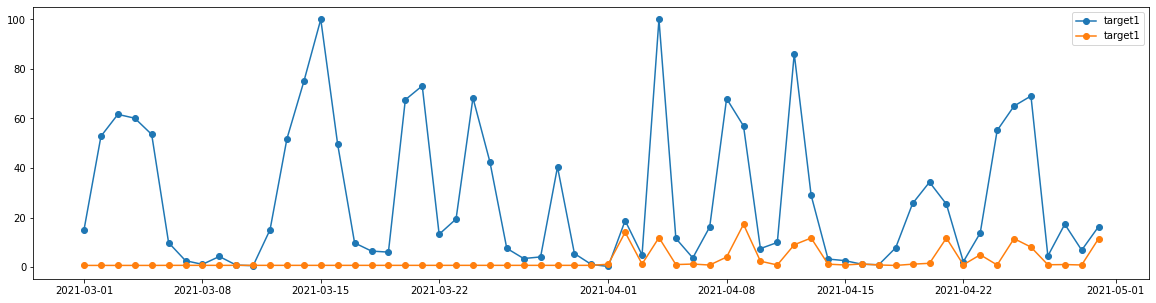

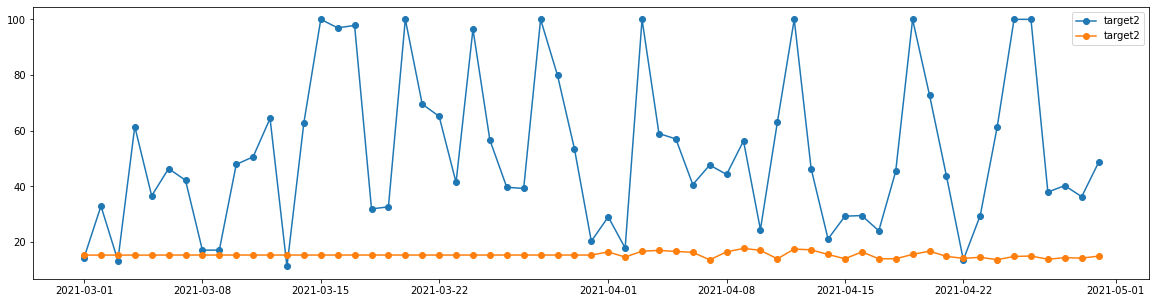

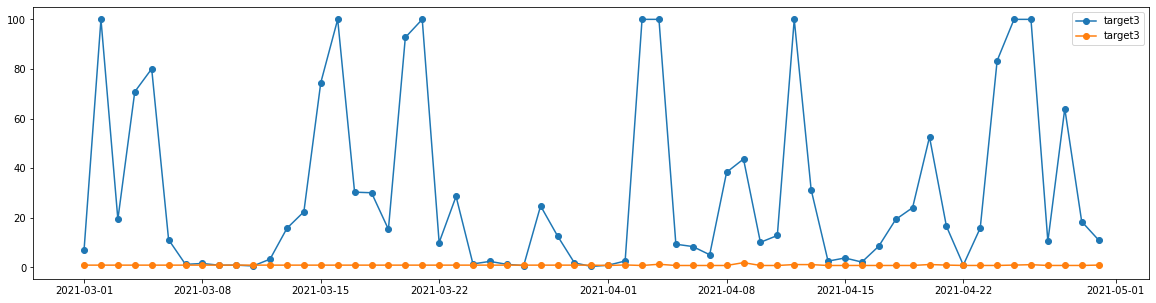

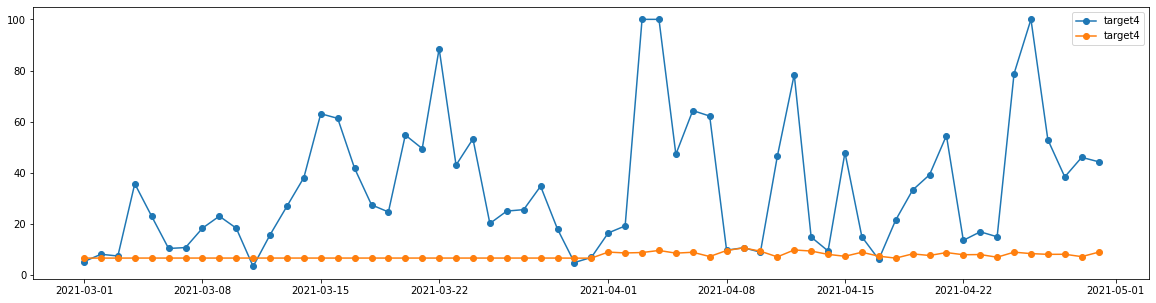

In [79]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)